In [19]:
# The HSIC Bottleneck: Deep Learning without Back-Propagation
# Wan-Duo Kurt Ma, J.P. Lewis, W. Bastiaan Kleijn

# In this paper, the HSIC bottleneck method has been proposed to provide a deep classification  
# training approach without backpropagation. In tis approach, the mutual information has been 
# replaced with HSIC, which provides a robust computation with a time complexity O(m^3) that m 
# is the batch size. In this paper, the HSIC has been shown by Eq. (3). The authors used the 
# normalized HSIC (nHSIC) with the Eq. (4), in their experiements. Finally, to train the network 
# using the nHSIC, the loss function has been proposed using Eq. (6). The following code, is the 
# implementation of the paper using pytorch library. The sklearn and matplotlib libraries  were used 
# to get the rbf kernel function and plot tool respectively. 
# This code has been written by : Mohammad Anvaripour, moh.anvaripour@gmail.com

In [20]:
# Import the required libraries 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torchvision.transforms import ToTensor
from sklearn.metrics.pairwise import rbf_kernel
from torchsummary import summary
import matplotlib.pyplot as plt


In [21]:
# Define the network model. The input and output values of the layer have been selected based  
# on the MNIST image sizes and proposed values in the paper. The layers names are started by 'fc'. 
# The activation function for each hidden layer is ReLu. The Softmax is used for the last layer 
# to provide a classification result.

class net_model(nn.Module):
    def __init__(self):
        super(net_model, self).__init__()
        self.fc1 = nn.Linear(784, 256)  # self.fc1 = nn.Linear(3072, 256) #CIFAR10 dataset
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.drp = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 10)
        self.f2 = nn.Softmax(dim = 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.drp(x)
        x = torch.relu(self.fc4(x))
        x = self.f2(self.fc5(x))
        return x

In [22]:
# Define the extractore. This class is used to get the hidden layers output to calculate the Kz.

class Extractor(nn.Module):
    def __init__(self, model : nn.Module):
        super(Extractor, self).__init__()
        self.extractor_pre = 'fc'
        self.all_layers = []
        for name, layer in model.named_children():
            setattr(self, name, layer)
            self.all_layers.append(name)
        # set all_layers to tuple, fix its order
        self.all_layers = tuple(self.all_layers)
    
    
    def forward(self, data):
        x = data
        hidden = {}
        for name in self.all_layers:
            name : str
            layer = getattr(self,name)
            x = layer(x)
            if name.startswith(self.extractor_pre):
                hidden[name] = x
        return x, hidden

In [23]:
# Define the calss HSIC-bottleneck. The step function calculates the Kx, Ky, and Kz.  
# The loss function is calculated using the Eq. (6) in the paper.
# The Kx, Ky, and Kz are calculated using the rbf_kernel and the equation mentioned in section 2 of the paper.

class HSICBottleneck():
    def __init__(self, model, batch_size, beta, sigma, lr):
        super().__init__()
        self.model      = Extractor(model)
        self.batch_size = batch_size
        self.beta       = beta
        self.sigma      = sigma
        self.extractor  = 'fc'
        self.lr         = lr
        summary(model, input_size=(784, ))
        # summary(model, input_size=(3072, )) # For CIFAR10 Dataset
        self.remember = []
        
    def step(self, input_data, labels):
        
        # The apllied MNIST data batch is in the shape [batchsize, 1, 28, 28]. This tensor is reshaped to 2D 
        # with the shape [batch_size, 28*28]
        
        input_data_2d = input_data.view(input_data.shape[0], -1).to(device)
        labels = labels.float()
         
        Kx = torch.tensor(rbf_kernel(input_data_2d.cpu().numpy(), gamma=1.0 / 
                                     (input_data.shape[0]*2.0 * self.sigma ** 2)))
        Ky = torch.tensor(rbf_kernel(labels.cpu().numpy().reshape(-1,1), gamma=1.0 / 
                                     (input_data.shape[0]*2.0 * self.sigma ** 2)))

        y_pred, hidden_zs = self.model(input_data)
        total_HSIC_loss = 0.
        for name, layer in self.model.named_children():
            if self.extractor in name:
                hidden_z = hidden_zs[name]

                # Reshape hidden_z to 2D
                hidden_z_2d = hidden_z.view(hidden_z.shape[0], -1)

                Kz = torch.tensor(rbf_kernel(hidden_z_2d.detach().cpu().numpy(), gamma=1.0 / 
                                             (input_data.shape[0]*2.0 * self.sigma ** 2))).to(device)
                
                loss = nHSIC(Kz, Kx, input_data.shape[0]) - self.beta * nHSIC(Kz, Ky, input_data.shape[0]) # Eq. (6)
                total_HSIC_loss = total_HSIC_loss + self.lr*loss


        return total_HSIC_loss

In [24]:
def nHSIC(K1, K2, batch_size):
    # Calculate the normalized HSIC using the centered K1 and K2 matrixes, as mentioned in the Eq. (5)
    
    n = K1.shape[0]
    H = torch.eye(n) - 1 / n * torch.ones(n, n).to(device)

    K1_centered = H @ K1 @ H
    K2_centered = H @ K2 @ H
    
    IM = torch.eye(n)
    K1_centered_2 = K1_centered / (K1_centered + 0.001*batch_size*IM)
    K2_centered_2 = K2_centered / (K2_centered + 0.001*batch_size*IM)
    
    nHSIC_value = torch.trace(K1_centered_2 @ K2_centered_2) / ((batch_size - 1) ** 2)

    return nHSIC_value

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 256]          65,792
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
            Linear-5                   [-1, 10]           2,570
           Softmax-6                   [-1, 10]               0
Total params: 335,114
Trainable params: 335,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.28
Estimated Total Size (MB): 1.29
----------------------------------------------------------------
Epoch: 0 [0/60000 (0%)]	Loss: 2.683825
Epoch: 0 [12800/60000 (21%)]	Loss: 2.110683
Epoch: 0 [25600/60000 (43%)]	Loss: 1.987231
Epoch: 0 [38400/60000 (64%)]	Loss: 2.016500

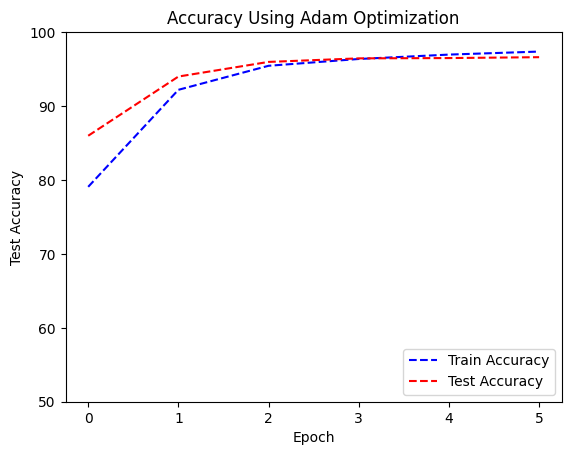

In [26]:
# The proposed model is trained in this section. The MNIST dataset is loaded for training and testing.
# In this section, Adam optimization is applied.

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset = MNIST(root='./data', train=True, transform=ToTensor())
    test_dataset = MNIST(root='./data', train=False, transform=ToTensor())

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)
    model = net_model()
    HSIC_loss = HSICBottleneck(model, batch_size=256, beta=0.0500, sigma=10., lr=0.1)
    model.to(device)
    lr = 0.1
    num_epochs = 6
    loss_fn = nn.CrossEntropyLoss()
    correct_result = []
    test_epoch = []
    correct_train = []
    
    for epoch in range(num_epochs):
        optimizer = optim.Adam(model.parameters())
        #optimizer = optim.SGD(model.parameters(), lr)
        
        model.train()
        model.batch_size = len(train_loader.dataset)
        correct = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            
            hh = data.shape
            data_2 = data.view(hh[0], -1)
            target_2 = target.unsqueeze(1)
            
            data_2, target_2 = data_2.to(device), target_2.to(device)
            output = model(data_2)
            loss_m = loss_fn(output, target)
            

            loss = HSIC_loss.step(data_2, target_2)
            
            optimizer.zero_grad()
            total_loss = loss + loss_m 
            total_loss.backward()
            optimizer.step()

                  
            
            output = model(data_2)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).float().sum()

            if batch_idx % 50 == 0:
                
                print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data_2), 
                    len(train_loader.dataset), 100. * batch_idx / len(train_loader), total_loss))
        
        accuracy = 100 * correct / len(train_loader.dataset)
        print("Accuracy = {}".format(accuracy))
        correct_train.append(accuracy)
        
        
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, 28 * 28)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            print(f'Test Accuracy of the model on the {total} test images: {100 * correct / total} %')
            correct_result.append(100 * correct / total)  
            test_epoch.append(epoch)
            
    plt.plot(test_epoch, correct_train, 'b--' , label='Train Accuracy' )
    plt.plot(test_epoch, correct_result, 'r--', label='Test Accuracy')
    plt.legend(loc="lower right")
    plt.ylabel('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylim((50,100))
    plt.title('Accuracy Using Adam Optimization')
    plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 256]          65,792
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
            Linear-5                   [-1, 10]           2,570
           Softmax-6                   [-1, 10]               0
Total params: 335,114
Trainable params: 335,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.28
Estimated Total Size (MB): 1.29
----------------------------------------------------------------
Epoch: 0 [0/60000 (0%)]	Loss: 2.683815
Epoch: 0 [12800/60000 (21%)]	Loss: 2.683657
Epoch: 0 [25600/60000 (43%)]	Loss: 2.683675
Epoch: 0 [38400/60000 (64%)]	Loss: 2.682816

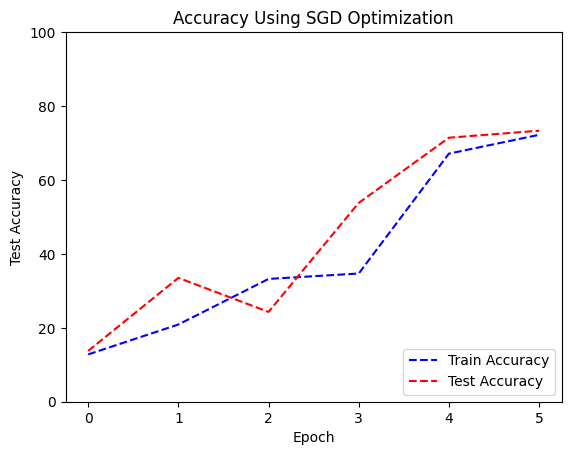

In [28]:
# The proposed model is trained in this section. The MNIST dataset is loaded for training and testing.
# In this section, SGM optimization is applied.

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_dataset = MNIST(root='./data', train=True, transform=ToTensor())
    test_dataset = MNIST(root='./data', train=False, transform=ToTensor())

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)
    model = net_model()
    HSIC_loss = HSICBottleneck(model, batch_size=256, beta=0.0500, sigma=10., lr=0.1)
    model.to(device)
    lr = 0.1
    num_epochs = 6
    loss_fn = nn.CrossEntropyLoss()
    correct_result = []
    test_epoch = []
    correct_train = []
    
    for epoch in range(num_epochs):
        #optimizer = optim.Adam(model.parameters())
        optimizer = optim.SGD(model.parameters(), lr)
        
        model.train()
        model.batch_size = len(train_loader.dataset)
        correct = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            
            hh = data.shape
            data_2 = data.view(hh[0], -1)
            target_2 = target.unsqueeze(1)
            
            data_2, target_2 = data_2.to(device), target_2.to(device)
            output = model(data_2)
            loss_m = loss_fn(output, target)
            

            loss = HSIC_loss.step(data_2, target_2)
            
            optimizer.zero_grad()
            total_loss = loss + loss_m 
            total_loss.backward()
            optimizer.step()

                
            
            output = model(data_2)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).float().sum()

            if batch_idx % 50 == 0:
                
                print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data_2), 
                    len(train_loader.dataset), 100. * batch_idx / len(train_loader), total_loss))
        
        accuracy = 100 * correct / len(train_loader.dataset)
        print("Accuracy = {}".format(accuracy))
        correct_train.append(accuracy)
        
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, 28 * 28)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
            print(f'Test Accuracy of the model on the {total} test images: {100 * correct / total} %')
            correct_result.append(100 * correct / total)  
            test_epoch.append(epoch)
            
    plt.plot(test_epoch, correct_train, 'b--' , label='Train Accuracy' )
    plt.plot(test_epoch, correct_result, 'r--', label='Test Accuracy')
    plt.legend(loc="lower right")
    plt.ylabel('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylim((0,100))
    plt.title('Accuracy Using SGD Optimization')
    plt.show()